# Import Libraries and fetch data

In [1]:
# import pandas for dataframe manipulation and other utilities
import pandas as pd

# import numpy for array-wise operations and other math utilities
import numpy as np

# import pyplot as foundational visualization library
import matplotlib.pyplot as plt

# import PCA for principal component analysis
from sklearn.decomposition import PCA

# import pca library for comprehensive PCA analysis and prep tools
from pca import pca as pca_funct
rand_state = 42

# import seaborn for additional visualization functions
import seaborn as sns

# filter out warnings to clean up output
import warnings
warnings.filterwarnings('ignore')

# import data
df = pd.read_csv('data/medical_clean.csv')

# import manually created data definitons as lookup table for differentiating qualitative/quantitative columns for processing
df_var_definitions = pd.read_csv('data/var_definitions.csv', encoding = 'unicode_escape', engine ='python')

In [2]:
# create copy of dataframe for further manipulation
df_init = df.copy(deep=True)

# strip any whitespace to avoid frustrating naming mismatches
df_init = df_init.rename(columns=lambda x: x.strip())

# fetch column mapping from var definition file
new_col_df = df_var_definitions.copy(deep=True)

var_dict = new_col_df.set_index('Variable Name')['Standardized Name'].to_dict()

# rename columns using the mapping defined above
df_init.rename(columns = var_dict, inplace=True)

# verify that our data variable type dictionary values are distinct and only contain two values: Qualitative and Quantitative
set(df_var_definitions['Data Type (Quantitative/Qualitative)'])

# create two lists of columns: one of all qualitative columns and one of all quantitative columns
qualitative_columns = []
quantitative_columns = []
unmapped_columns = []

map_count = 0

# test and add columns to appropriate list based on stripped column name from var list
for column in df_init.columns:
    curr_type = df_var_definitions.loc[df_var_definitions['Standardized Name'].str.strip() == column,'Data Type (Quantitative/Qualitative)']

    try:
        if curr_type.size > 0:
            if curr_type.values[0] == 'Qualitative':
                qualitative_columns.append(column)
                
            elif curr_type.values[0] == 'Quantitative':
                quantitative_columns.append(column)
                
        else:
            unmapped_columns.append(column)
            
    except:
        print('something went wrong')
        
# count mapped columns
map_count = len(qualitative_columns) + len(quantitative_columns)

# compare total column count vs. mapped and display warning if mismatched
print(f'{"--"*20}\n {map_count} of {len(df_init.columns)} columns mapped successfully \n{"--"*20}')

if len(unmapped_columns) > 0:
    print(f'WARNING: Unable to map some columns: {unmapped_columns} \n{"=="*20}')

----------------------------------------
 50 of 50 columns mapped successfully 
----------------------------------------


In [3]:
# display type and number of quantitative colunns found
df_init[quantitative_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lat                 10000 non-null  float64
 1   lng                 10000 non-null  float64
 2   population          10000 non-null  int64  
 3   children            10000 non-null  int64  
 4   age                 10000 non-null  int64  
 5   income              10000 non-null  float64
 6   vit_d_levels        10000 non-null  float64
 7   doc_visits          10000 non-null  int64  
 8   full_meals_eaten    10000 non-null  int64  
 9   vit_d_supp          10000 non-null  int64  
 10  initial_days        10000 non-null  float64
 11  total_charge        10000 non-null  float64
 12  additional_charges  10000 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 1015.8 KB


# Select features

<Axes: >

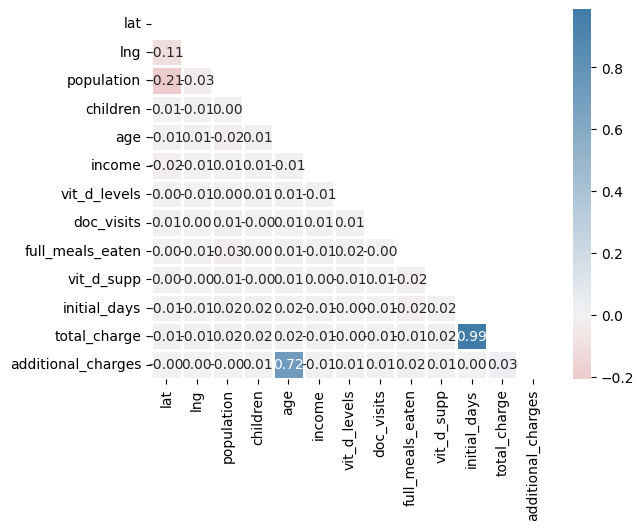

In [4]:
corr = df_init[quantitative_columns].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(h_neg=10,h_pos=240, as_cmap=True)

sns.heatmap(corr, mask=mask, center=0, cmap=cmap, linewidths=1, annot=True, fmt=".2f")

In [5]:
# dropping initial_days due to near 1 correlation with total_charge
df_pca = df_init[['lat','lng','population','children','age','income','vit_d_levels', 'doc_visits', 'full_meals_eaten', 'vit_d_supp','total_charge','additional_charges']]


# Select best features for PCA 

# Train PCA model on normalized data

In [6]:
model = pca_funct(n_components=.8, normalize=True)
outcomes = model.fit_transform(df_pca)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [80.0%] explained variance using the [12] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [80.00%] explained variance.
[pca] >The PCA reduction is performed on the [12] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[9]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


# Display loading matrix

In [7]:
loadings = outcomes['loadings']
loadings

,lat,lng,population,children,age,income,vit_d_levels,doc_visits,full_meals_eaten,vit_d_supp,total_charge,additional_charges
PC1,-0.003706,0.007387,-0.021805,0.024164,0.705026,-0.022866,0.019563,0.013734,0.026960,0.019631,0.045578,0.705356
PC2,-0.711906,0.264705,0.629980,-0.021566,0.005293,0.068761,-0.021333,0.013909,-0.110972,0.038684,0.080536,0.008921
PC3,0.122277,-0.607933,0.282769,0.392144,-0.024649,0.055112,0.013090,0.071921,-0.205467,0.294348,0.493819,-0.005270
PC4,-0.087242,-0.216542,0.173680,0.236578,-0.020788,-0.193647,0.568556,0.002147,0.578013,-0.402200,-0.046981,-0.010099
PC5,0.029517,-0.262329,0.122271,-0.092707,0.023619,0.623964,0.025845,0.566065,0.015149,-0.056661,-0.437907,0.024034
PC6,-0.042485,-0.031279,-0.032818,0.440297,0.014930,0.438405,-0.403111,-0.474680,0.028523,-0.468634,-0.035805,0.017984
PC7,0.007831,-0.534935,0.282328,-0.563669,0.024480,-0.164157,-0.255950,-0.394948,0.112704,-0.021306,-0.230783,0.029878
PC8,-0.058782,0.071364,-0.068587,0.105724,-0.007323,0.345736,0.219052,-0.408536,0.361068,0.689366,-0.188281,-0.007212
PC9,-0.050674,0.051986,-0.016638,0.027523,-0.027520,-0.087786,-0.591942,0.339420,0.667467,0.132535,0.237485,-0.012345


# Scree plot and % of explained variance

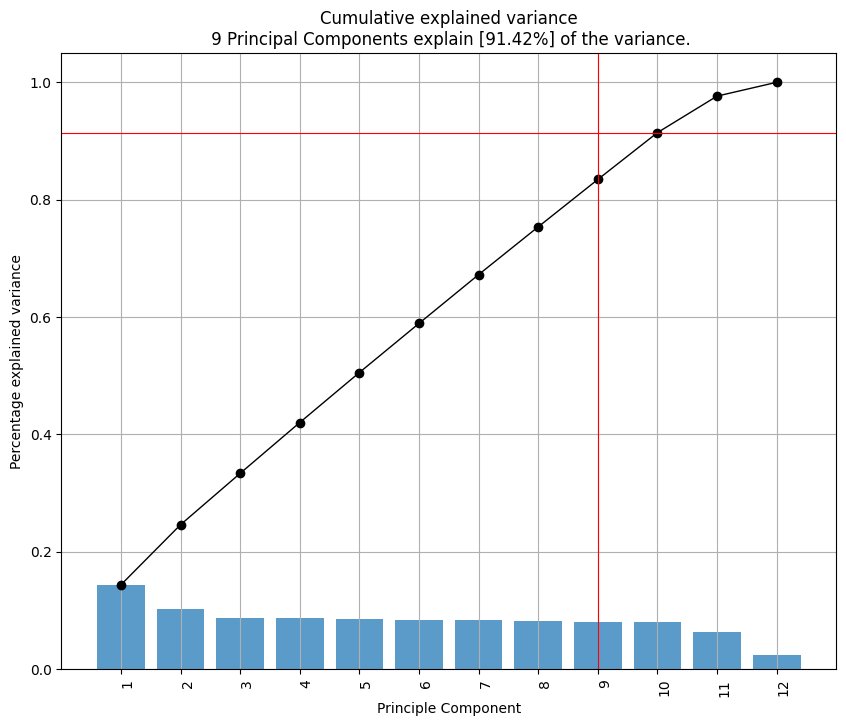

In [8]:
model.plot(figsize=(10,8))
plt.show()

In [9]:
# create alternate plotting of PCA for elbow method

# create normalized version of dataframe (Middleton 2021a)
df_pca_normalized = (df_pca-df_pca.mean())/df_pca.std()

# perform PCA (Middleton 2021a)
pca = PCA(n_components=df_pca.shape[1])

# fit model
pca.fit(df_pca_normalized)

# load results into dataframe
df_pca = pd.DataFrame(pca.transform(df_pca_normalized))

# Create loadings (Middleton 2021a)
loadings = pd.DataFrame(pca.components_.T, index=df_pca_normalized.columns)
loadings

# create covariance matrix (Middleton 2021a)
cov_matrix = np.dot(df_pca_normalized.T, df_pca_normalized)/df_pca.shape[0]



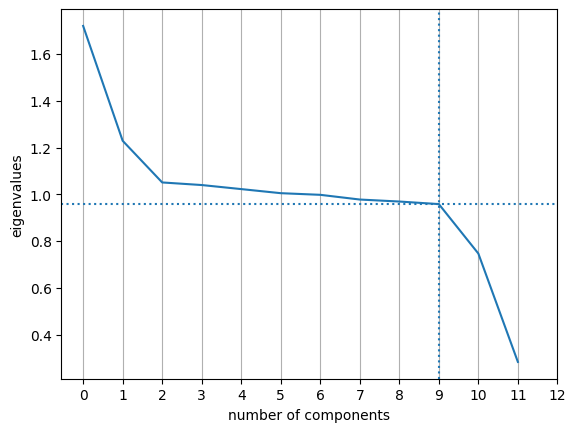

In [10]:
# get eigen values (Middleton 2021a)
eigenvalues=[np.dot(eigenvector.T,np.dot(cov_matrix, eigenvector)) for eigenvector in pca.components_]

# load eigen values into a scree plot
# scree plot shows that keeping components 3
# will be most effective (Middleton 2021a)

plt.plot(eigenvalues)
plt.xlabel('number of components')
plt.ylabel('eigenvalues')
plt.xticks(range(0,13))
plt.grid(axis='x')
plt.axhline(y=eigenvalues[9], linestyle = ":")
plt.axvline(x=9, linestyle= ":")
plt.show()

In [11]:
outcomes['topfeat']

,PC,feature,loading,type
0,PC1,additional_charges,0.705356,best
1,PC2,lat,-0.711906,best
2,PC3,lng,-0.607933,best
3,PC4,full_meals_eaten,0.578013,best
4,PC5,income,0.623964,best
5,PC6,doc_visits,-0.474680,best
6,PC7,children,-0.563669,best
7,PC8,vit_d_supp,0.689366,best
8,PC9,full_meals_eaten,0.667467,best
9,PC2,population,0.629980,weak
